In [240]:
from warnings import filterwarnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T

from sklearn import datasets
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.4


In [241]:
import pandas as pd

In [242]:
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
filterwarnings("ignore")
sns.set_style("white")

In [243]:
datas = pd.read_csv("Naive-Bayes-Classification-Data.csv")
datas.head()

,glucose,bloodpressure,diabetes
0,40,85,0
1,40,92,0
2,45,63,1
3,45,80,0
4,40,73,1


In [244]:
X = datas.iloc[:,[0,1]].values
Y = datas.iloc[:,-1].values
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((720, 2), (180, 2), (720,), (180,))

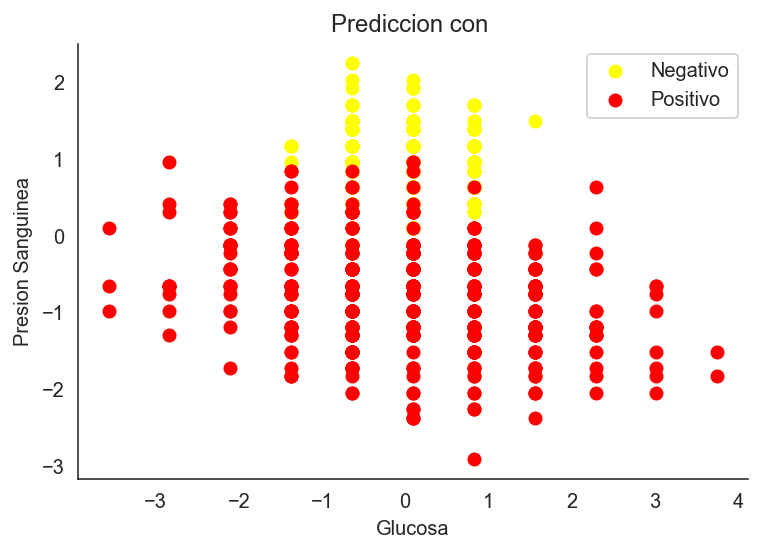

In [245]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color="yellow",label="Negativo")
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="red", label="Positivo")
sns.despine()
ax.legend()
ax.set(xlabel="Glucosa", ylabel="Presion Sanguinea", title="Prediccion con ");

In [246]:
def construct_nn(X_train, Y_train):
    n_hidden = 1

    # Iniciamos las capas con numeros aleatorios
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        ann_input = pm.Data("ann_input", X_train)
        ann_output = pm.Data("ann_output", Y_train)

        # La capa inicial con una oculta
        weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(X.shape[1], n_hidden), testval=init_1)
        # capa oculta
        weights_1_2 = pm.Normal("w_1_2", 0, sigma=1, shape=(n_hidden, n_hidden), testval=init_2)
        # capa de salida
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, shape=(n_hidden,), testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
        )
    return neural_network


neural_network = construct_nn(X_train, Y_train)

In [247]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=160000, method=inference)

Finished [100%]: Average Loss = 165.69


Wall time: 2min 18s


In [248]:
trace = approx.sample(draws=5000)

In [249]:
# create symbolic input
x = T.matrix("X")
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar("n")
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(
    neural_network.out.distribution.p, size=n, more_replacements={neural_network["ann_input"]: x}
)
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

# Create bechmark functions
def production_step1():
    pm.set_data(new_data={"ann_input": X_test, "ann_output": Y_test}, model=neural_network)
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)
    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc["out"].mean(axis=0) > 0.5

def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5

In [250]:
%timeit production_step1()

12.1 s ± 2.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [251]:
%timeit production_step2()

50.2 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [267]:
pred = sample_proba(X_test, 20).mean(0) > 0.5
count = 0
i = 0
lim = X_test.shape[0]
while(i<lim):
    if (int(pred[i])==int(Y_test[i])):
        count = count + 1
    i = i + 1
count,lim

(167, 180)

In [270]:
tests = pd.read_csv("outputs.csv")
X1 = tests.iloc[:,[0,1]].values
X1 = scale(X1)
X1 = X1.astype(floatX)
Y1 = Y1.astype(floatX)
Y1 = tests.iloc[:,-1].values

In [271]:
pred = sample_proba(X1, 20).mean(0) > 0.5
count = 0
i = 0
lim = X1.shape[0]
while(i<lim):
    if (int(pred[i])==int(Y1[i])):
        count = count + 1
    i = i + 1
count,lim

(87, 96)

### Red Neuronal Convulocional
#### https://docs.pymc.io/en/stable/pymc-examples/examples/variational_inference/bayesian_neural_network_advi.html
### Pandas
#### https://pandas.pydata.org/pandas-docs/version/0.25.1/reference/api/pandas.DataFrame.as_matrix.html